In [1]:
def Run_GeoShapes_Exp(Num_Epochs):
    %matplotlib notebook
    import keras as keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D,MaxPool2D
    from keras.losses import binary_crossentropy, categorical_crossentropy
    from keras.metrics import categorical_accuracy
    from keras import regularizers,optimizers
    from keras.regularizers import l2
    import numpy as np
    import scipy.io
    import matplotlib.pyplot as plt
    import gzip
    from keras.layers.core import Lambda
    from scipy.integrate import trapz
    import seaborn as sns

    from keras.layers.core import Lambda
    from keras import backend as K    
    
    def Get_Feats_and_Targets(filename):
        import numpy as np

        def line_to_Feats(line):
            line = line.split(' ')
            Feats = np.asarray(line[0:1024])
            Target = np.zeros([3])
            Target[int(line[1024])] = 1
            return Feats,Target

        f = open(filename, 'r')
        lines = f.readlines()
        Features = []
        Targets = []
        for i in range(len(lines)-1):
            line = lines[i+1]
            Feats,Tgts = line_to_Feats(line)
            Features.append(Feats)
            Targets.append(Tgts)

        return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')
    
    [TrainInputs_Easy,TrainTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')
    [TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.10000.train.amat')
    [ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.valid.amat')
    
    TrainInputs = np.append(TrainInputs,TrainInputs_Easy,axis=0)
    TrainTargets = np.append(TrainTargets,TrainTargets_Easy,axis=0)

    data_dim = TrainInputs.shape[1]
    NumSamples = TrainInputs.shape[0]
    Num_Targets = TrainTargets.shape[-1]


    reg_coeff = 0

    def Gen_Model(reg_coeff):
        model = Sequential()
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.0001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
        return model

    VarTempModel = Gen_Model(reg_coeff)
    UniTaskModel = Gen_Model(reg_coeff)
    PropTaskModel = Gen_Model(reg_coeff)
    ConstTempModel = Gen_Model(reg_coeff)
    Uni_model = Gen_Model(reg_coeff)
    
    VarTempModel.set_weights(Uni_model.get_weights())
    UniTaskModel.set_weights(Uni_model.get_weights())
    PropTaskModel.set_weights(Uni_model.get_weights())
    ConstTempModel.set_weights(Uni_model.get_weights())
    
    def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Exp_Dist_to_Threshold *= 1
    #     Exp_Dist_to_Threshold = Dist_to_Threshold
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob

    def acquisition_function_dist_to_threshold_const_temp(model,samples,Num_Targets,temperature=1):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        return Sampling_Prob

    count = 0 
    Num_Epochs = Num_Epochs
    Num_BurnIn = 1
    Batch_Size = 32
    
    NumTasks = 2
    try:
        SwitchPoint = np.int(Num_Epochs/NumTasks)
        print('Switch:')
        print(SwitchPoint)
    except:
        SwitchPoint = 1
    Val_Error = np.zeros([Num_Epochs,5])
    Val_Acc = np.zeros([Num_Epochs,5])

    def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
        
    def Biased_Batch_Uni(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
                Sampling_Probability[TaskInd] = 1
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
            
    fig = plt.figure(figsize = [4,4])
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    fig2 = plt.figure(figsize = [4,4])
    ax2 = fig2.add_subplot(111)
    plt.ion()
    fig2.show()
    fig2.canvas.draw()


    for EpochLoop in  range(Num_Epochs):
        if count < Num_BurnIn:
            Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,:] = Error[0]
            Val_Acc[count,:] = Error[1]
            
            VarTempModel.set_weights(Uni_model.get_weights())
            UniTaskModel.set_weights(Uni_model.get_weights())
            PropTaskModel.set_weights(Uni_model.get_weights())
            ConstTempModel.set_weights(Uni_model.get_weights())
        else:
            
            VarTempModel_Probability = acquisition_function_dist_to_threshold(VarTempModel,TrainInputs,Num_Targets,1,10)
            VarTempModel_Probability/= VarTempModel_Probability.sum().astype(float)
            
            UniTaskModel_Probability = acquisition_function_dist_to_threshold_const_temp(UniTaskModel,TrainInputs,Num_Targets,1)
            UniTaskModel_Probability/= UniTaskModel_Probability.sum().astype(float)
            
            PropTaskModel_Probability = acquisition_function_dist_to_threshold(PropTaskModel,TrainInputs,Num_Targets,1,10)
            PropTaskModel_Probability/= PropTaskModel_Probability.sum().astype(float)
            
            ConstTempModel_Probability = acquisition_function_dist_to_threshold_const_temp(ConstTempModel,TrainInputs,Num_Targets,0.5)
            ConstTempModel_Probability/= ConstTempModel_Probability.sum().astype(float)
            
            print(np.max(ConstTempModel_Probability)/np.min(ConstTempModel_Probability))
            
            VarTempModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,VarTempModel_Probability,0,0,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            UniTaskModel.fit_generator(Biased_Batch_Uni(TrainInputs,TrainTargets,Batch_Size,UniTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),  
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            PropTaskModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,PropTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            ConstTempModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,ConstTempModel_Probability,0,0,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

            Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples),0),
                                    steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

            Error = VarTempModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,0] = Error[0]
            Val_Acc[count,0] = Error[1]

            Error = UniTaskModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,1] = Error[0]
            Val_Acc[count,1] = Error[1]
            
            Error = PropTaskModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,2] = Error[0]
            Val_Acc[count,2] = Error[1]
            
            Error = ConstTempModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]

            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,4] = Error[0]
            Val_Acc[count,4] = Error[1]
            
            print(EpochLoop)

        count += 1
        
        ax.clear()
        ax.plot(Val_Error[0:count,0],label='VarTemp')
        ax.plot(Val_Error[0:count,1],label='UniTask')
        ax.plot(Val_Error[0:count,2],label='PropTask')
        ax.plot(Val_Error[0:count,3],label='ConstTemp')
        ax.plot(Val_Error[0:count,4],label='Uniform')
        ax.legend(loc='best')
        fig.canvas.draw()

        ax2.clear()
        ax2.plot(Val_Acc[0:count,0],label='High D2T')
        ax2.plot(Val_Acc[0:count,1],label='UniTask')
        ax2.plot(Val_Acc[0:count,2],label='PropTask')
        ax2.plot(Val_Acc[0:count,3],label='ConstTemp')
        ax2.plot(Val_Acc[0:count,4],label='Uniform')
        fig2.canvas.draw()

    [TestInputs,TestTargets] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.test.amat')

    TestError = np.zeros([5,2])
    TestError[0,:] = VarTempModel.test_on_batch(TestInputs,TestTargets)
    TestError[1,:] = UniTaskModel.test_on_batch(TestInputs,TestTargets)
    TestError[2,:] = PropTaskModel.test_on_batch(TestInputs,TestTargets)
    TestError[3,:] = ConstTempModel.test_on_batch(TestInputs,TestTargets)
    TestError[4,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
    
    

    return TestError, Val_Error,Val_Acc

In [2]:
import numpy as np
import datetime
NumRuns = 100
NumEpochs = 350

TestError = np.zeros([5,2,NumRuns])
Val_Error = np.zeros([NumEpochs,5,NumRuns])
Val_Acc = np.zeros([NumEpochs,5,NumRuns])


0


Using TensorFlow backend.


Switch:
175


<IPython.core.display.Javascript object>


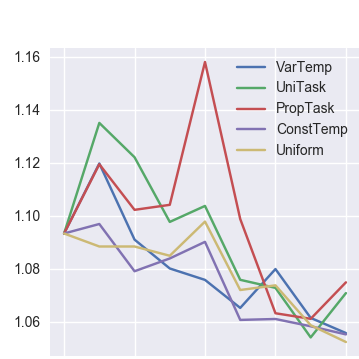

<IPython.core.display.Javascript object>


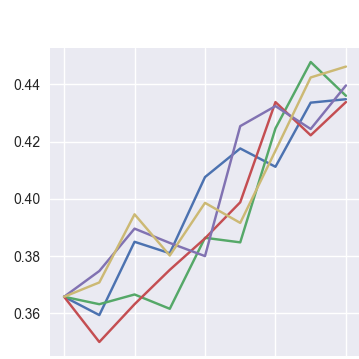

Epoch 1/1
20000/20000 [==============================] - 5s 255us/step - loss: 1.1753 - categorical_accuracy: 0.3425
3.2441022
1
3.3988512
2
4.739889
3
6.8376007
4
8.465301
5
9.45477
6
9.853366
7
10.5842705
8
11.852879


In [ ]:
from IPython.display import clear_output
for i in range(NumRuns):
    clear_output()
    print(i)
    TestError[:,:,i],Val_Error[:,:,i],Val_Acc[:,:,i] = Run_GeoShapes_Exp(NumEpochs)
    np.save("Test_Performance_Geo_Various",TestError)
    np.save("Val_Error_Geo_Various",Val_Error)
    np.save("Val_Acc_Geo_Various",Val_Acc)
    


In [8]:
Val_Error.shape

(1, 3)

In [1]:
5/3

1.6666666666666667

In [7]:
np.max([-33,0])

0